# Etivity 3

### Student: Christos Koutsiaris

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

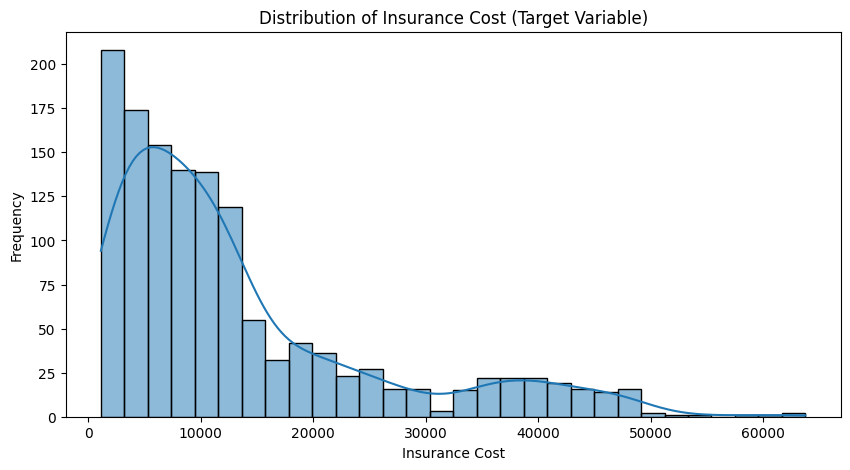

In [29]:
RANDOM_STATE = 42
N_JOBS       = -1
CV_SPLITS    = 5

df = pd.read_csv("insurance.csv")
X  = df.drop(columns=["insurance_cost"])
y  = df["insurance_cost"]


# -------------------------------------------------------------------
# Check how target distribution
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True)
plt.title('Distribution of Insurance Cost (Target Variable)')
plt.xlabel('Insurance Cost')
plt.ylabel('Frequency')
plt.show()

In [31]:
# -------------------------------------------------------------------
# Train - test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

numeric_features   = ["age", "bmi", "children"]
categorical_features = ["gender", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough' 
)

temp_preprocessor = preprocess.fit(X_train)
n_features_after_preprocessing = temp_preprocessor.transform(X_train).shape[1]
print(f"Number of features after preprocessing: {n_features_after_preprocessing}")

Number of features after preprocessing: 8


In [33]:
# -------------------------------------------------------------------
# Three pipelines
#    LinearRegression + PCA
#    RandomForest + RFE
#    GradientBoosting + SelectKBest
# -------------------------------------------------------------------
pipelines = {
    "linreg_pca": Pipeline(
        steps=[
            ("prep", preprocess),
            ("pca", PCA(random_state=RANDOM_STATE)),
            ("reg", LinearRegression()),
        ]
    ),
    "rf_rfe": Pipeline(
        steps=[
            ("prep", preprocess),
            ("rfe", RFE(
                estimator=RandomForestRegressor( 
                    n_estimators=100, random_state=RANDOM_STATE 
                ),
                step=1,
            )),
            ("reg", RandomForestRegressor(random_state=RANDOM_STATE)),
        ]
    ),
    "gbr_kbest": Pipeline(
        steps=[
            ("prep", preprocess),
            ("kbest", SelectKBest(score_func=f_regression)),
            ("reg", GradientBoostingRegressor(random_state=RANDOM_STATE)),
        ]
    ),
}

# -------------------------------------------------------------------
# Hyper‑parameter grids
# -------------------------------------------------------------------
param_grids = {
    "linreg_pca": {
        # PCA components <= 8
        "pca__n_components": [0.80, 0.90, 0.95, 5, 7, 8],
        "reg__fit_intercept": [True, False]
    },
    "rf_rfe": {
        # RFE features <= 8
        "rfe__n_features_to_select": [5, 7, 8], # Corrected values
        "reg__n_estimators": [300, 600],
        "reg__max_depth": [None, 8, 16],
    },
    "gbr_kbest": {
         # KBest k <= 8
        "kbest__k": [5, 7, 8], # Corrected values
        "reg__n_estimators": [200, 400],
        "reg__learning_rate": [0.05, 0.1],
        "reg__max_depth": [2, 3, 4],
    },
}

# -------------------------------------------------------------------
# Model selection 
# -------------------------------------------------------------------
results = []
best_estimators_reg = {}

cv = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for name, pipe in pipelines.items():
    print(f"=== {name} ===")
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=cv,
        n_jobs=N_JOBS,
        scoring="neg_root_mean_squared_error", # RMSE (lower is better)
        refit=True, # Keep True
    )
    grid.fit(X_train, y_train)

    best_estimators_reg[name] = grid.best_estimator_ 

    y_pred  = grid.best_estimator_.predict(X_test)
    metrics = {
        "model": name,
        "best_params": grid.best_params_,
        "test_RMSE":  np.sqrt(mean_squared_error(y_test, y_pred)), 
        "test_MAE":   mean_absolute_error(y_test, y_pred),
        "test_R2":    r2_score(y_test, y_pred),
    }
    results.append(metrics)
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Test Set Metrics: RMSE={metrics['test_RMSE']:.2f}, MAE={metrics['test_MAE']:.2f}, R2={metrics['test_R2']:.3f}")
    print()

# -------------------------------------------------------------------
# Comparison
# -------------------------------------------------------------------
results_df = pd.DataFrame(results).sort_values("test_RMSE")
print(results_df)

=== linreg_pca ===
Best Parameters: {'pca__n_components': 8, 'reg__fit_intercept': True}
Test Set Metrics: RMSE=6000.00, MAE=4307.78, R2=0.745

=== rf_rfe ===
Best Parameters: {'reg__max_depth': 8, 'reg__n_estimators': 600, 'rfe__n_features_to_select': 7}
Test Set Metrics: RMSE=4329.91, MAE=2485.09, R2=0.867

=== gbr_kbest ===
Best Parameters: {'kbest__k': 8, 'reg__learning_rate': 0.05, 'reg__max_depth': 2, 'reg__n_estimators': 200}
Test Set Metrics: RMSE=4155.28, MAE=2422.15, R2=0.878

        model                                        best_params    test_RMSE  \
2   gbr_kbest  {'kbest__k': 8, 'reg__learning_rate': 0.05, 'r...  4155.276516   
1      rf_rfe  {'reg__max_depth': 8, 'reg__n_estimators': 600...  4329.909989   
0  linreg_pca  {'pca__n_components': 8, 'reg__fit_intercept':...  6000.001809   

      test_MAE   test_R2  
2  2422.147666  0.877760  
1  2485.093327  0.867269  
0  4307.778697  0.745131  



--- Visual Comparison of Metrics ---


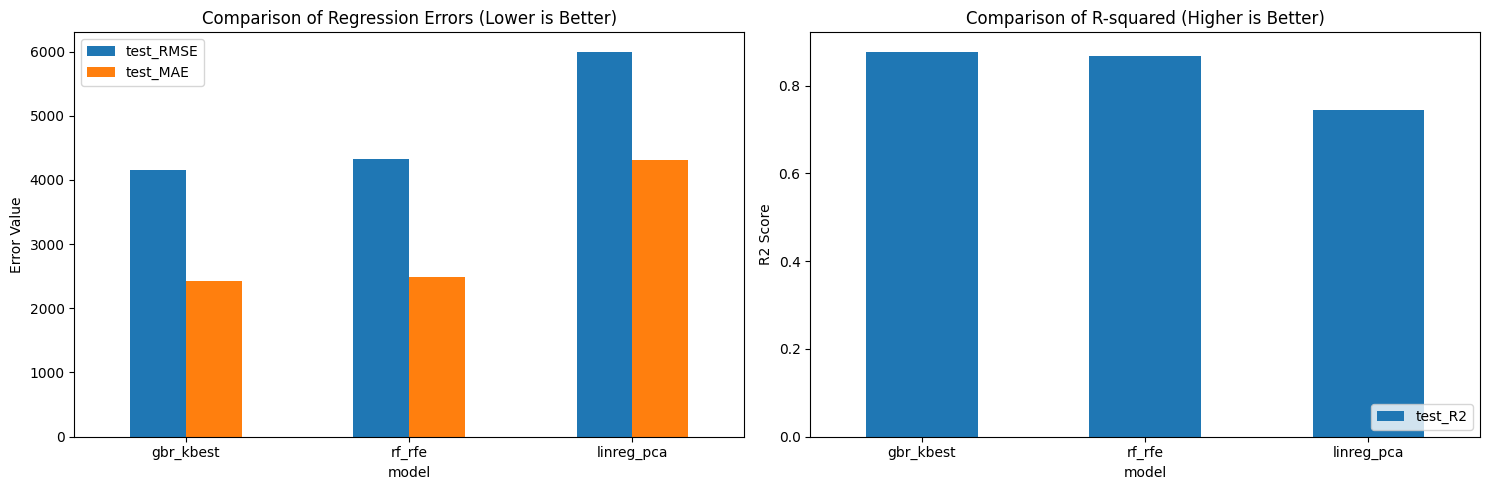


--- Prediction vs Actual Values ---


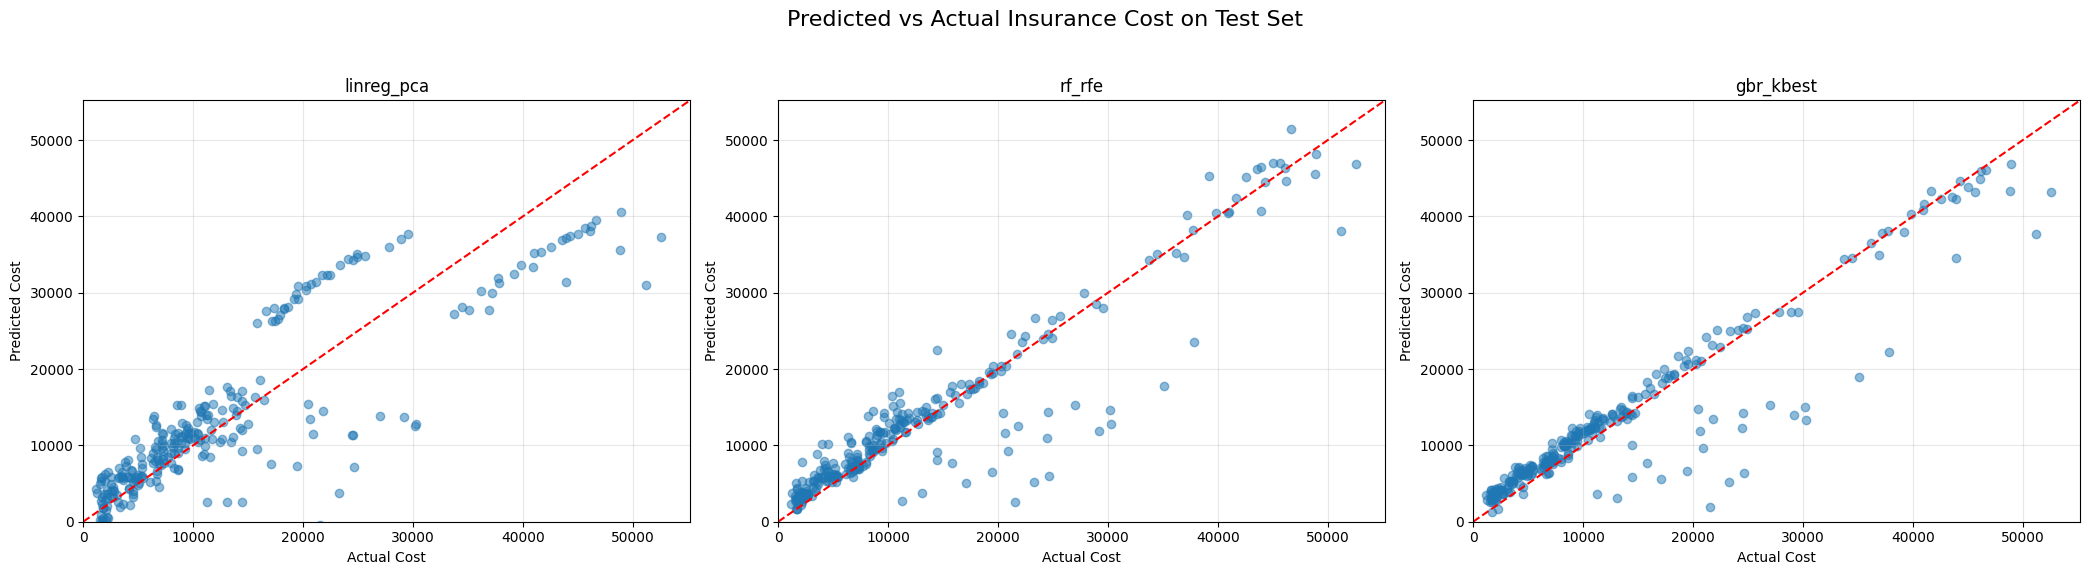

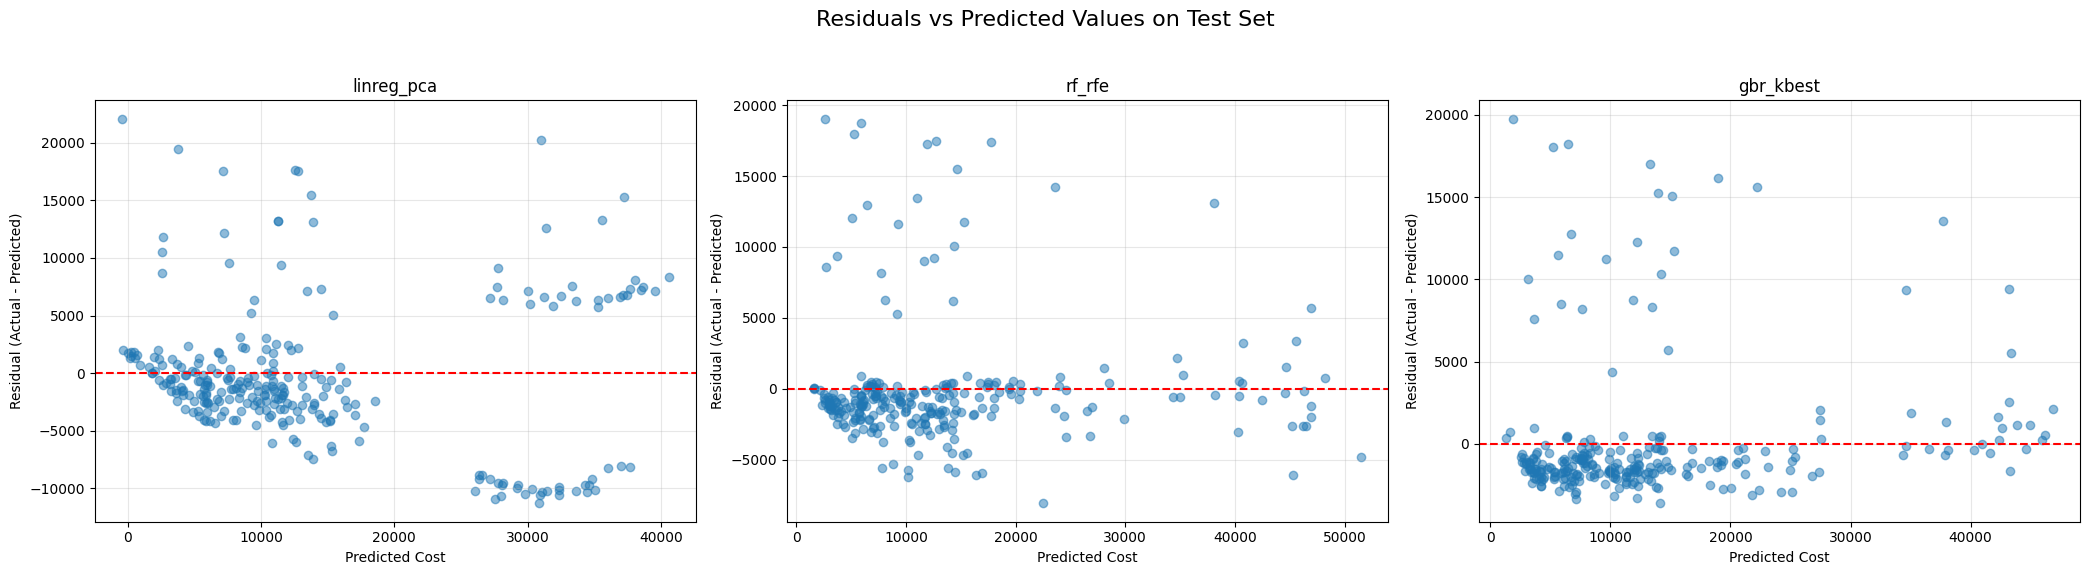

Mismatch between feature names (8) and importances (7) for rf_rfe.


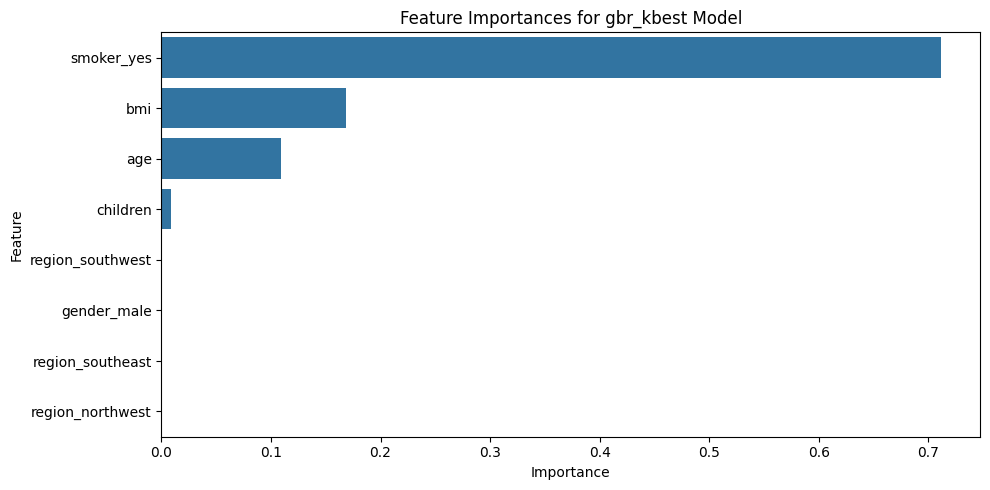

In [34]:
# -------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------

print("\n--- Visual Comparison of Metrics ---")
metrics_to_plot = ['test_RMSE', 'test_MAE'] # Lower is better for these
df_plot_error = results_df.set_index('model')[metrics_to_plot]

df_plot_r2 = results_df.set_index('model')[['test_R2']] # Higher is better

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df_plot_error.plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparison of Regression Errors (Lower is Better)')
axes[0].set_ylabel('Error Value')
axes[0].tick_params(axis='x', rotation=0)

df_plot_r2.plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparison of R-squared (Higher is Better)')
axes[1].set_ylabel('R2 Score')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


print("\n--- Prediction vs Actual Values ---")
fig, axes = plt.subplots(1, len(best_estimators_reg), figsize=(7 * len(best_estimators_reg), 6))
fig.suptitle('Predicted vs Actual Insurance Cost on Test Set', fontsize=16)

if len(best_estimators_reg) == 1: 
     axes = [axes]

model_names_reg = list(best_estimators_reg.keys())
max_val = max(y_test.max(), max(model.predict(X_test).max() for model in best_estimators_reg.values())) * 1.05 

for i, name in enumerate(model_names_reg):
    model = best_estimators_reg[name]
    y_pred = model.predict(X_test)
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([0, max_val], [0, max_val], 'r--') # Line y=x
    axes[i].set_title(name)
    axes[i].set_xlabel('Actual Cost')
    axes[i].set_ylabel('Predicted Cost')
    axes[i].set_xlim(0, max_val)
    axes[i].set_ylim(0, max_val)
    axes[i].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


fig, axes = plt.subplots(1, len(best_estimators_reg), figsize=(7 * len(best_estimators_reg), 6))
fig.suptitle('Residuals vs Predicted Values on Test Set', fontsize=16)

if len(best_estimators_reg) == 1:
     axes = [axes]

for i, name in enumerate(model_names_reg):
    model = best_estimators_reg[name]
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    axes[i].scatter(y_pred, residuals, alpha=0.5)
    axes[i].axhline(y=0, color='r', linestyle='--') # Line y=0
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted Cost')
    axes[i].set_ylabel('Residual (Actual - Predicted)')
    axes[i].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def get_feature_names(column_transformer):
    output_features = []
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            all_features = column_transformer.feature_names_in_
            transformed_features = []
            for n, _, f in column_transformer.transformers_:
                 if n != 'remainder':
                     transformed_features.extend(f)
            remainder_features = [f for f in all_features if f not in transformed_features]
            output_features.extend(remainder_features)

        elif hasattr(pipe, 'get_feature_names_out'):
             try:
                 feature_names = pipe.get_feature_names_out(features)
                 output_features.extend(feature_names)
             except TypeError:
                 feature_names = pipe.get_feature_names_out()
                 output_features.extend(feature_names)
        elif name != 'remainder': 
             output_features.extend(features)

    return output_features

for name, pipeline in best_estimators_reg.items():
    if hasattr(pipeline.named_steps['reg'], 'feature_importances_'):
        preprocessor_step = pipeline.named_steps['prep']
        dim_reduction_step = pipeline.named_steps.get('reduce_dim', None) 
        regressor_step = pipeline.named_steps['reg']

        feature_names_after_prep = get_feature_names(preprocessor_step)

        if dim_reduction_step and hasattr(dim_reduction_step, 'support_'): 
            selected_features_mask = dim_reduction_step.support_
            final_feature_names = np.array(feature_names_after_prep)[selected_features_mask]
        elif dim_reduction_step and isinstance(dim_reduction_step, PCA):
             n_components = regressor_step.feature_importances_.shape[0]
             final_feature_names = [f'PC{i+1}' for i in range(n_components)]
        else: # No dim reduction or step not recognized
            final_feature_names = feature_names_after_prep

        importances = regressor_step.feature_importances_

        if len(final_feature_names) == len(importances):
            feature_importance_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            # Plot
            plt.figure(figsize=(10, max(5, len(final_feature_names) * 0.4)))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title(f'Feature Importances for {name} Model')
            plt.tight_layout()
            plt.show()
        else:
             print(f"Mismatch between feature names ({len(final_feature_names)}) and importances ({len(importances)}) for {name}.")


### Summary of Regression Task

In this notebook, my goal was to predict the specific insurance_cost for individuals. I developed and compared three different regression methods for this: Linear Regression using PCA for feature reduction, Random Forest using RFE, and Gradient Boosting using SelectKBest. To prepare the data before training, I scaled the numerical features using StandardScaler and converted categorical features into numbers using OneHotEncoder. Each pipeline also incorporated one of the mentioned techniques to reduce the number of input features.

I used GridSearchCV to automatically find the best settings (hyperparameters) for both the feature reduction part and the main regression model within each pipeline. During this tuning process, I used the negative root mean squared error as the measure to decide which settings were optimal. I set up the parameter grids so that the RFE and SelectKBest steps only considered selecting a valid number of features (8 or fewer) based on the data after preprocessing.

After finding the best version of each pipeline, I compared their performance on the unseen test data using RMSE, MAE, and R2 scores. The results showed that both the Random Forest and Gradient Boosting models performed significantly better than the Linear Regression model. The Gradient Boosting Regressor, when combined with SelectKBest (which, in its best run, chose to use all 8 features), gave slightly better results – it had the lowest RMSE and MAE, and the highest R2 score. Based on this evaluation, I chose Gradient Boosting as the preferred model for predicting insurance costs with this dataset. Visual checks using the Prediction vs Actual and Residual plots further confirmed that the tree-based models provided a much better fit than linear regression for this specific data.